# R Exercises - part 5
- Name: Alberto Coppi
- Student ID: 2053063
- E-mail: <alberto.coppi@studenti.unipd.it>

## Import useful libraries

In [50]:
library(ggplot2)
library(gridExtra)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ purrr::cross()   masks pracma::cross()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()



In [48]:
install.packages(c("tidyverse", "dplyr"))

Installing packages into ‘/home/alberto/R/x86_64-pc-linux-gnu-library/4.2’
(as ‘lib’ is unspecified)

also installing the dependencies ‘backports’, ‘blob’, ‘DBI’, ‘data.table’, ‘gargle’, ‘cellranger’, ‘ids’, ‘broom’, ‘dbplyr’, ‘dtplyr’, ‘forcats’, ‘googledrive’, ‘googlesheets4’, ‘haven’, ‘modelr’, ‘readxl’, ‘reprex’, ‘rvest’, ‘tidyr’




## Ex1 - Radioactive source

In [2]:
Dt  <- 10
obs <- c(4, 1, 3, 1, 3)

### a)
Assuming a flat prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +1$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

In [3]:
u_alpha  <- sum(obs) + 1
u_lambda <- length(obs)

u_posterior <- function(mu) {dgamma(mu, shape=u_alpha, rate=u_lambda)}

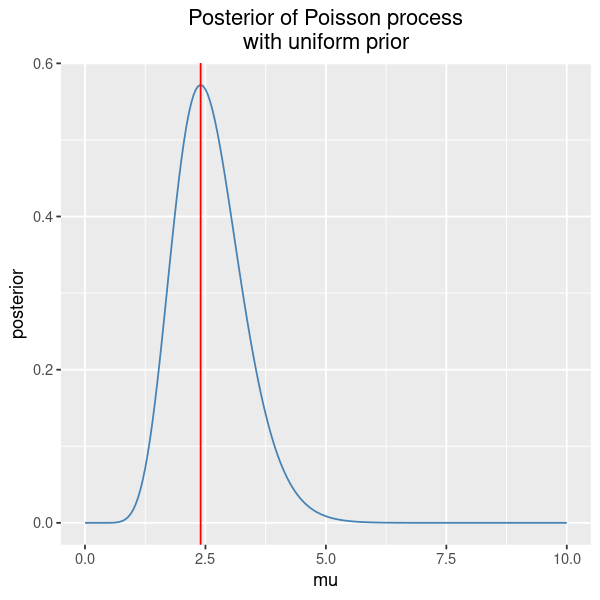

In [4]:
plot_pdf <- function(pdf, title) {
    mus <- seq(0, 10, length.out=201)

    options(repr.plot.width=5, repr.plot.height=5)
    plt <- ggplot(data.frame(mu=mus, posterior=pdf(mus)), aes(x=mu, y=posterior)) +
           geom_path(color='steelblue') +
           geom_vline(aes(xintercept=mu[which.max(posterior)]), color='red') +
           labs(title=title) +
           theme(plot.title=element_text(hjust=0.5))
    show(plt)
}

plot_pdf(u_posterior, 'Posterior of Poisson process\nwith uniform prior')

Now we calculate analitically and numerically the mean, median and variance. As the Gamma distribution has no analitical form to calculate the median, we calculate it using `qgamma`

In [5]:
u_mean.th   <- u_alpha/u_lambda
u_median.th <- qgamma(0.5, u_alpha, u_lambda)                              # alpha*(1-1/(9*alpha))^3
u_var.th    <- u_alpha/(u_lambda^2)

n_momentum <- function(n, pdf) {
    integrate(function(x) {x^n*pdf(x)}, lower=0, upper=Inf)[[1]]
}   

# experimental mean
u_mean.exp   <- n_momentum(1, u_posterior)

# experimental median
x <- 0
precision <- 10^-4
while(TRUE) {
    z <- integrate(u_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
u_median.exp <- x

# experimental variance
u_var.exp    <- n_momentum(2, u_posterior) - u_mean.exp^2

df <- data.frame(mean=c(u_mean.th, u_mean.exp), 
                 median=c(u_median.th, u_median.exp), 
                 variance=c(u_var.th, u_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.6,2.533646,0.52
Num.,2.6,2.533700,0.52


### b)
Assuming a Jeffrey's prior the posterior of a Poisson process is the Gamma distribution $Gamma(\mu|\alpha, \lambda)$ with $\alpha=(\sum_{i=1}^n x_i) +\frac{1}{2}$ and $\lambda=n$ where ${x_i}$ is the set of observations and $n$ its magnitude.

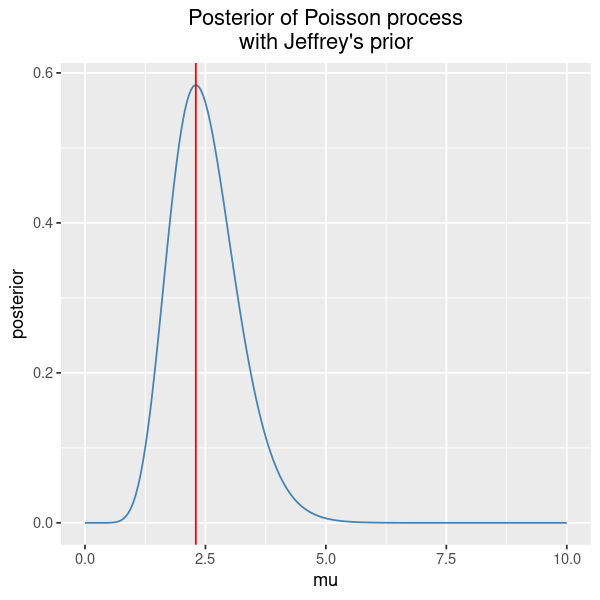

In [6]:
j_alpha  <- sum(obs) + 1/2
j_lambda <- length(obs)

j_posterior <- function(mu) {dgamma(mu, shape=j_alpha, rate=j_lambda)}

plot_pdf(j_posterior, "Posterior of Poisson process\nwith Jeffrey's prior")

In [7]:
j_mean.th   <- j_alpha/j_lambda
j_median.th <- qgamma(0.5, j_alpha, j_lambda)                              # alpha*(1-1/(9*alpha))^3
j_var.th    <- j_alpha/(j_lambda^2)

# experimental mean
j_mean.exp   <- n_momentum(1, j_posterior)

# experimental median
x <- 0
while(TRUE) {
    z <- integrate(j_posterior, lower=0, upper=x)[[1]]
    if(z>=0.5) break
    else x <- x+precision
}
j_median.exp <- x

# experimental variance
j_var.exp    <- n_momentum(2, j_posterior) - j_mean.exp^2

df <- data.frame(mean=c(j_mean.th, j_mean.exp), 
                 median=c(j_median.th, j_median.exp), 
                 variance=c(j_var.th, j_var.exp))
rownames(df) <- c('Analy.', 'Num.')
df

,mean,median,variance
,<dbl>,<dbl>,<dbl>
Analy.,2.5,2.433659,0.5
Num.,2.5,2.433700,0.5


### c)

In [8]:

confidence_interval <- function(mean, dist, ..., cl=0.95, precision=10^-4) {
    a <- mean
    b <- mean
    while (TRUE) {
        z <- integrate(dist, lower=a, upper=mean, ...)[[1]] +
             integrate(dist, lower=mean, upper=b, ...)[[1]]
        if(z > cl) break
        else if(a-precision >= 0) {
            if(a-precision >= 0) a <- a-precision
            b <- b+precision  
        }
        else b <- b+precision 
    }
    return(c(a, b))
}

In [9]:
cl=0.95

ci.unif <- confidence_interval(u_mean.th, u_posterior, cl=cl)
ci.jeff <- confidence_interval(j_mean.th, j_posterior, cl=cl)

ci.unif.norm <- c(qnorm( (1-cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ), 
                  qnorm( (1+cl)/2, mean=u_mean.th, sd=sqrt(u_var.th) ))
ci.jeff.norm <- c(qnorm( (1-cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ), 
                  qnorm( (1+cl)/2, mean=j_mean.th, sd=sqrt(j_var.th) ))


cat(sprintf("Posterior with uniform prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f", 
    u_mean.th, cl*100, ci.unif[[1]], ci.unif[[2]], ci.unif.norm[[1]], ci.unif.norm[[2]]), '\n')
cat(sprintf("Posterior with Jeffrey's prior:\n\tMean\t\t: %.2f\n\t%i%% C.I.\t: %.4f - %.4f\n\tnorm approx.\t: %.4f - %.4f",
    j_mean.th, cl*100, ci.jeff[[1]], ci.jeff[[2]], ci.jeff.norm[[1]], ci.jeff.norm[[2]]), '\n')

Posterior with uniform prior:
	Mean		: 2.60
	95% C.I.	: 1.2146 - 3.9854
	norm approx.	: 1.1866 - 4.0134 
Posterior with Jeffrey's prior:
	Mean		: 2.50
	95% C.I.	: 1.1425 - 3.8575
	norm approx.	: 1.1141 - 3.8859 


## Ex2 - Lighthouse problem

To solve this problem we take into account the exercise done in class. The only difference is the fact that the parameter $\beta$ is not fixed. Thus, the analytical form of the likelihood remains unchanged, while the prior changes.  
In this case, given that $\alpha$ and $\beta$ are independent from each other we take a uniform prior for both of them. The analytical form is:
$
    P(\alpha, \beta) = 
$

In [32]:
alpha.min <- -8
alpha.max <- 8
beta.min  <- 0
beta.max  <- 4
precision <- 0.5*10^-2
old.data <- 0

log.likelihood <- function( alpha, beta, data ) {
    l <- 0
    for( x in data ) {
        l <- l - log(beta^2 + (x-alpha)^2)          # log for more precise computation
    }
    return(l + log(beta)*length(data))
}

evidence <- function( data ) {
    # check data in order to avoid useless recomputing
    if(sum(data == old.data) != length(old.data)) {
        grid <- list(seq(alpha.min, alpha.max, by=precision), seq(beta.min, beta.max, by=precision))
        integral <- 0
        for(alpha in grid[[1]]) {
            for(beta in grid[[2]]) {
                integral <- integral + exp(log.likelihood( alpha, beta, data ))
            }
        }
        evidenceEval <<- integral*precision^2
        old.data <<- data
    }
    
    return(evidenceEval)
}

posterior <- function( alpha, beta, data ) {
    
    return(exp(outer(alpha, beta, FUN=log.likelihood, data))/evidence(data))
}

In [89]:
data <- rnorm(10, 2, 3)
evidence(data)

[1] 1.044073e-05

In [100]:
alpha <- seq(alpha.min, alpha.max, by=0.1)
beta  <- seq(beta.min, beta.max, by=0.1)
values <- posterior(alpha, beta, data)
colnames(values) <- beta
data2plot <- data.frame(values) %>% 
        cbind(alpha) %>% 
        pivot_longer(names_to='beta', values_to='post', -alpha) %>% 
        mutate(beta=as.numeric(str_replace(beta, "X", ""))) 
plt <- ggplot(data2plot, aes(x=alpha, y=beta, fill=post)) +
       geom_raster() +
       scale_fill_gradientn(colours=terrain.colors(10)) +
       theme_classic()
show(plt)
ggsave('prova.pdf', plt)

Saving 6.67 x 6.67 in image



In [78]:
values <- posterior(alpha, beta, data)
data.frame( %>% colnames() <- )

alpha,beta,X1,X2,X3,X4,X5,X6,X7,X8,⋯,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-8.0000000,0.0000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-7.1578947,0.2105263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-6.3157895,0.4210526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-5.4736842,0.6315789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-4.6315789,0.8421053,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-3.7894737,1.0526316,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.9473684,1.2631579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2.1052632,1.4736842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1.2631579,1.6842105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,⋯,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
alpha <- seq(alpha.min, alpha.max, length.out=20)
beta <- seq(beta.min, beta.max, length.out=20)

posterior(alpha, beta, data)

0,4.669443e-05,0.0001848105,0.0004086351,0.0007092408,0.0010752729,0.001493868,0.001951580,0.002435201,0.002932417,0.003432267,0.003925393,0.004404141,0.004862515,0.005296056,0.005701657,0.006077367,0.006422186,0.006735873,0.007018778
0,9.027222e-05,0.0003549236,0.0007764264,0.0013285217,0.0019798136,0.002697483,0.003450420,0.004211395,0.004958195,0.005673896,0.006346528,0.006968400,0.007535286,0.008045630,0.008499822,0.008899612,0.009247637,0.009547064,0.009801333
0,2.112291e-04,0.0008171485,0.0017428268,0.0028868885,0.0041448120,0.005426366,0.006663994,0.007813560,0.008850691,0.009765633,0.010558367,0.011234737,0.011803684,0.012275437,0.012660403,0.012968541,0.013209044,0.013390220,0.013519470
0,7.267535e-04,0.0026502621,0.0051954528,0.0078192816,0.0101922485,0.012185282,0.013788922,0.015045876,0.016013116,0.016745109,0.017288183,0.017679781,0.017949502,0.018120576,0.018211247,0.018235929,0.018206104,0.018131010,0.018018159
0,8.288410e-03,0.0173642070,0.0217372768,0.0237768725,0.0247828519,0.025284613,0.025510942,0.025570795,0.025521029,0.025393824,0.025208774,0.024978633,0.024712235,0.024416058,0.024095097,0.023753376,0.023394256,0.023020620,0.022634997
0,4.690458e-03,0.0131886125,0.0198117408,0.0239738286,0.0264721813,0.027961307,0.028832905,0.029310991,0.029526207,0.029557752,0.029455795,0.029253564,0.028974046,0.028633812,0.028245272,0.027818047,0.027359821,0.026876887,0.026374506
0,9.747194e-04,0.0036350664,0.0073450489,0.0114126958,0.0153183462,0.018771504,0.021662299,0.023989408,0.025803744,0.027174450,0.028171557,0.028858547,0.029290047,0.029511877,0.029562017,0.029471830,0.029267215,0.028969613,0.028596843
0,4.857948e-04,0.0018856538,0.0040417248,0.0067334360,0.0097226759,0.012791670,0.015765738,0.018520860,0.020980467,0.023106722,0.024890353,0.026341381,0.027481677,0.028339499,0.028945728,0.029331427,0.029526351,0.029558121,0.029451825
0,3.403946e-04,0.0013365031,0.0029167964,0.0049734444,0.0073764730,0.009988855,0.012679811,0.015334599,0.017860216,0.020187376,0.022269637,0.024080711,0.025610879,0.026863194,0.027849931,0.028589530,0.029104094,0.029417474,0.029553844
0,2.925661e-04,0.0011529212,0.0025309545,0.0043491933,0.0065107457,0.008908473,0.011434036,0.013985705,0.016474207,0.018826346,0.020986501,0.022916379,0.024593488,0.026008857,0.027164402,0.028070290,0.028742510,0.029200773,0.029466800
0,2.957856e-04,0.0011653244,0.0025571779,0.0043919563,0.0065706181,0.008984001,0.011522152,0.014082299,0.016574730,0.018926346,0.021082034,0.023004253,0.024671381,0.026075302,0.027218708,0.028112410,0.028772894,0.029220226,0.029476354


In [76]:
z <- posterior(alpha, beta, data)
colnames(z) <- beta
#rownames(z) <- alpha
data.frame(z) %>% cbind(alpha) %>% 
  pivot_longer(names_to='beta', values_to='post', -alpha) %>% mutate(beta=as.numeric(str_replace(beta, "X", ""))) 

alpha,beta,post
<dbl>,<dbl>,<dbl>
-8.000000,0.0000000,0.000000e+00
-8.000000,0.2105263,4.669443e-05
-8.000000,0.4210526,1.848105e-04
-8.000000,0.6315789,4.086351e-04
-8.000000,0.8421053,7.092408e-04
-8.000000,1.0526316,1.075273e-03
-8.000000,1.2631579,1.493868e-03
-8.000000,1.4736842,1.951580e-03
-8.000000,1.6842105,2.435201e-03


In [75]:
x <- 'X0.258'
as.numeric(str_replace(x, "X", ""))

[1] 0.258